# Evaluating the performance of the kataegis detection packages

This Jupyter notebook will reproduce the evaluation of kataegis detection packages as detailed within our manuscript.


## Loading/installing dependencies

First, we import the dependencies for this notebook. If the R dependencies are not installed, we install them.


In [5]:
# Install and load packages for kataegis analysis.
install.packages("librarian")
librarian::shelf(katdetectr, BiocManager, Biobase, eblondel / zen4R, mltools, VennDiagram, futile.logger, ggplot2, dplyr, VariantAnnotation, pbapply, SeqKat, doMC, ClusteredMutations, kataegis, maftools, flosalbizziae / kataegis)

# Set the seed for reproducibility
set.seed(1)


Installiere Paket nach '/Users/jobbie/Library/R/arm64/4.2/library'
(da 'lib' nicht spezifiziert)




Die heruntergeladenen Bin"arpakete sind in 
	/var/folders/35/vm9kcsm57tx2q1vv2pfl2p9c0000gn/T//RtmpU3BUMp/downloaded_packages


### Setting up SigProfiler dependencies (GRCh37)

Please note that sigprofiler needs to be installed separately.

```python
pip3 install SigProfilerClusters SigProfilerSimulator seaborn
```

In order for SigProfiles to run, we need to download the GRCh37 reference genome and the corresponding annotations.

```bash
python3 ../python/setupSigProfiler.py
```


## Importing Alexandrov et al. (2013) data and generating the synthetic datasets

### Reproducibility

All previously generated input and output for reproduction of the evaluation of kataegis detection packages as detailed within our manuscript were deposited on [Zenodo](https://doi.org/10.5281/zenodo.6810477) to allow re-generating the presented figures and tables. 

This will retrieve all the RData objects using in the latter part of this notebook. Uncomment and run the following cell to download the data.


In [2]:
# Increase the timeout (due to some large files).
options(timeout = 5000)

# Download the required files into the data/ folder (~1GB).
# zen4R::download_zenodo(doi = "10.5281/zenodo.6810477", path = "data/reproduction/", quiet = FALSE, overwrite = FALSE)

### Fresh run

#### Importing somatic variants and kataegis calls from Alexandrov et al. (2013)

The following code will download and pre-process the somatic variants and kataegis calls from Alexandrov et al. (2013). This will generate an RData object within the specified `path`.


In [7]:
source("R/1.importAndProcess_Alexandrov.R")
importAlexandrovData(path = "data/")

INFO [2023-06-07 15:28:13] Downloading somatic variants - Alexandrov et al. (2013)
INFO [2023-06-07 15:28:13] Processing somatic variants - Alexandrov et al. (2013)
INFO [2023-06-07 15:30:04] Downloading and importing kataegis calls - Alexandrov et al. (2013)
INFO [2023-06-07 15:30:04] Annotating samples with kataegis calls - Alexandrov et al. (2013)
INFO [2023-06-07 15:30:40] Converting to MAF files - Alexandrov et al. (2013)
INFO [2023-06-07 15:30:45] Saving processed Alexandrov et al. (2013) data under: data//alexandrov_data_processed.RData
INFO [2023-06-07 15:31:02] Done


### Generating synthetic datasets

The following code will generate a set of xxx synthetic samples (hg19) with varying degrees of kataegis events. This will generate an RData object within the specified `path`.


In [8]:
source("R/2.importAndProcess_Synthetic.R")
generateSyntheticData(path = "data/")

INFO [2023-06-07 15:33:53] Generating synthetic data
INFO [2023-06-07 15:36:54] Annotating the kataegis foci
INFO [2023-06-07 15:37:02] Converting to MAF format
INFO [2023-06-07 15:37:12] Saving to data//synthetic_data.RData


## Performing the various kataegis-detection packages

Next, we will perform the various R-based kataegis-detection packages (katdetectr, SeqKat, maftools, kataegis and ClusteredMutations) and python-based (SigProfilerClusters) on the same datasets (Alexandrov et al. and the synthetic dataset). This will generate RData objects containing the results within `data/`.


INFO [2023-06-07 15:44:19] Running all R-based tools on Alexandrov et al. (2013) dataset
INFO [2023-06-07 15:44:19] Loading RData object: Alexandrov et al. (2013) dataset
INFO [2023-06-07 15:44:29] Running katdetectr
  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

INFO [2023-06-07 15:44:38] Setting-up SeqKat requirements
INFO [2023-06-07 15:44:57] Running SeqKat
[1] "/var/folders/35/vm9kcsm57tx2q1vv2pfl2p9c0000gn/T//RtmpU3BUMp/001-0002-03TD.bed"


Testing Chromosome 1

Testing Chromosome 2

Testing Chromosome 3

Testing Chromosome 4

Testing Chromosome 5

Testing Chromosome 6

Testing Chromosome 7

Testing Chromosome 8

Testing Chromosome 9

Testing Chromosome 10

Testing Chromosome 11

Testing Chromosome 12

Testing Chromosome 13

Testing Chromosome 14

Testing Chromosome 15

Testing Chromosome 16

Testing Chromosome 17

Testing Chromosome 18

Testing Chromosome 19

Testing Chromosome 20

Testing Chromosome 21

Testing Chromosome 22

Testing Chromosome 23

Testing Chromosome 24



[1] "/var/folders/35/vm9kcsm57tx2q1vv2pfl2p9c0000gn/T//RtmpU3BUMp/003-0005-09TD.bed"


Testing Chromosome 1

Testing Chromosome 2

Testing Chromosome 3

Testing Chromosome 4

Testing Chromosome 5

Testing Chromosome 6

Testing Chromosome 7

Testing Chromosome 8

Testing Chromosome 9

Testing Chromosome 10

Testing Chromosome 11

Testing Chromosome 12

Testing Chromosome 13

Testing Chromosome 14

Testing Chromosome 15

Testing Chromosome 16

Testing Chromosome 17

Testing Chromosome 18

Testing Chromosome 19

Testing Chromosome 20

Testing Chromosome 21

Testing Chromosome 22

Testing Chromosome 23



[1] "/var/folders/35/vm9kcsm57tx2q1vv2pfl2p9c0000gn/T//RtmpU3BUMp/012-02-1TD.bed"


Testing Chromosome 1

Testing Chromosome 2

Testing Chromosome 3

Testing Chromosome 4

Testing Chromosome 5

Testing Chromosome 6

Testing Chromosome 7

Testing Chromosome 8

Testing Chromosome 9

Testing Chromosome 10

Testing Chromosome 11

Testing Chromosome 12

Testing Chromosome 13

Testing Chromosome 14

Testing Chromosome 15

Testing Chromosome 16

Testing Chromosome 17

Testing Chromosome 18

Testing Chromosome 19

Testing Chromosome 20

Testing Chromosome 21

Testing Chromosome 22

Testing Chromosome 23



[1] "/var/folders/35/vm9kcsm57tx2q1vv2pfl2p9c0000gn/T//RtmpU3BUMp/125.bed"


Testing Chromosome 1

Testing Chromosome 2

Testing Chromosome 3

Testing Chromosome 4

Testing Chromosome 5

Testing Chromosome 6

Testing Chromosome 7

Testing Chromosome 8

Testing Chromosome 9

Testing Chromosome 10

Testing Chromosome 11

Testing Chromosome 12

Testing Chromosome 13

Testing Chromosome 14

Testing Chromosome 15

Testing Chromosome 16

Testing Chromosome 17

Testing Chromosome 18

Testing Chromosome 19

Testing Chromosome 20

Testing Chromosome 21

Testing Chromosome 22

Testing Chromosome 23

Testing Chromosome 24



[1] "/var/folders/35/vm9kcsm57tx2q1vv2pfl2p9c0000gn/T//RtmpU3BUMp/128.bed"


Testing Chromosome 1

Testing Chromosome 2

Testing Chromosome 3

Testing Chromosome 4

Testing Chromosome 5

Testing Chromosome 6

Testing Chromosome 7

Testing Chromosome 8

Testing Chromosome 9

Testing Chromosome 10

Testing Chromosome 11

Testing Chromosome 12

Testing Chromosome 13

Testing Chromosome 14

Testing Chromosome 15

Testing Chromosome 16

Testing Chromosome 17

Testing Chromosome 18

Testing Chromosome 19

Testing Chromosome 20

Testing Chromosome 21

Testing Chromosome 22

Testing Chromosome 23

Testing Chromosome 24



INFO [2023-06-07 15:56:12] Running MafTools


Processing 001-0002-03TD..

No changepoints detected!

Processing 003-0005-09TD..

Kataegis detected at:



   Chromosome Start_Position End_Position nMuts Avg_intermutation_dist Size
1:         14      106326687    106329234     6                  509.4 2547
   Tumor_Sample_Barcode T>A T>C
1:        003-0005-09TD   3   3


Processing 012-02-1TD..



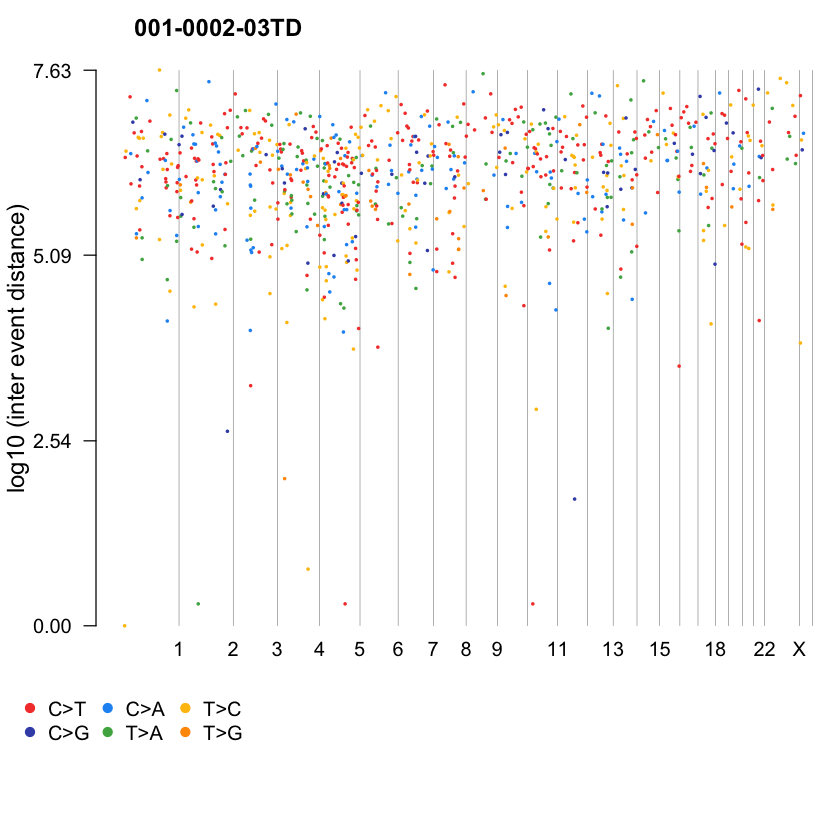

No changepoints detected!

Processing 125..



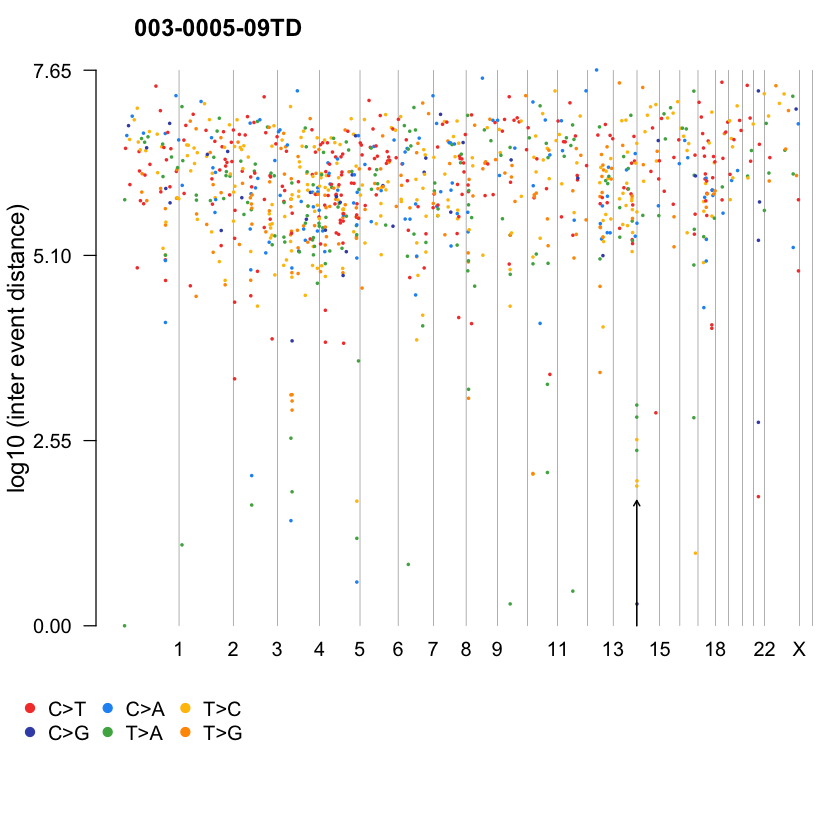

Kataegis detected at:



   Chromosome Start_Position End_Position nMuts Avg_intermutation_dist Size
1:         14      106323677    106329936    14               481.4615 6259
2:         22       23134942     23135427     6                97.0000  485
   Tumor_Sample_Barcode C>G C>T T>A T>C T>G
1:                  125   2   4   2   5   1
2:                  125   1  NA   1   3   1


Processing 128..



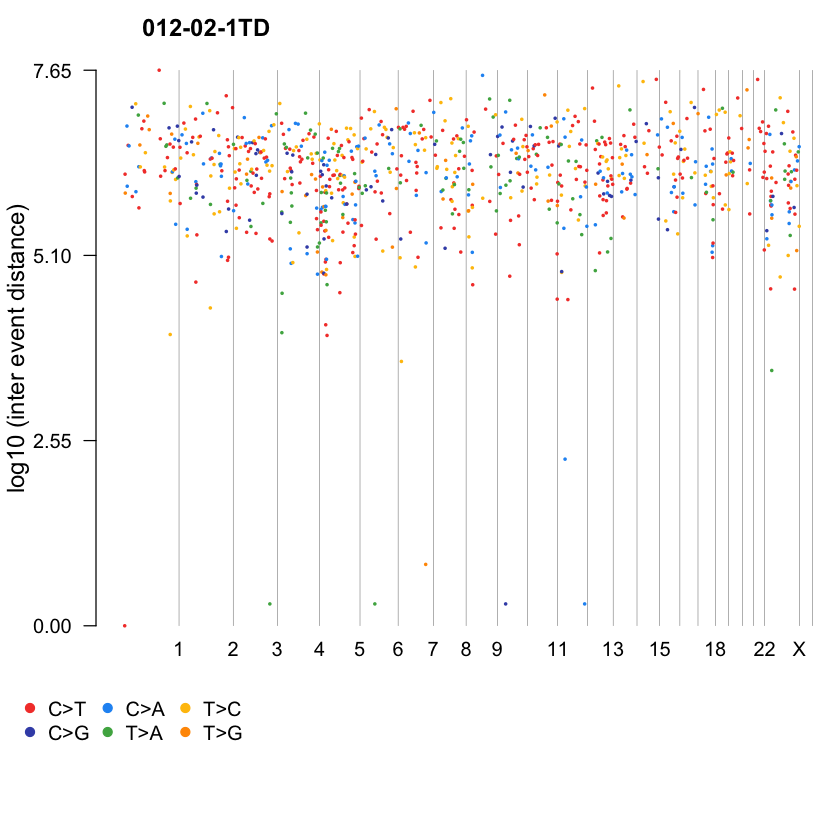

No changepoints detected!



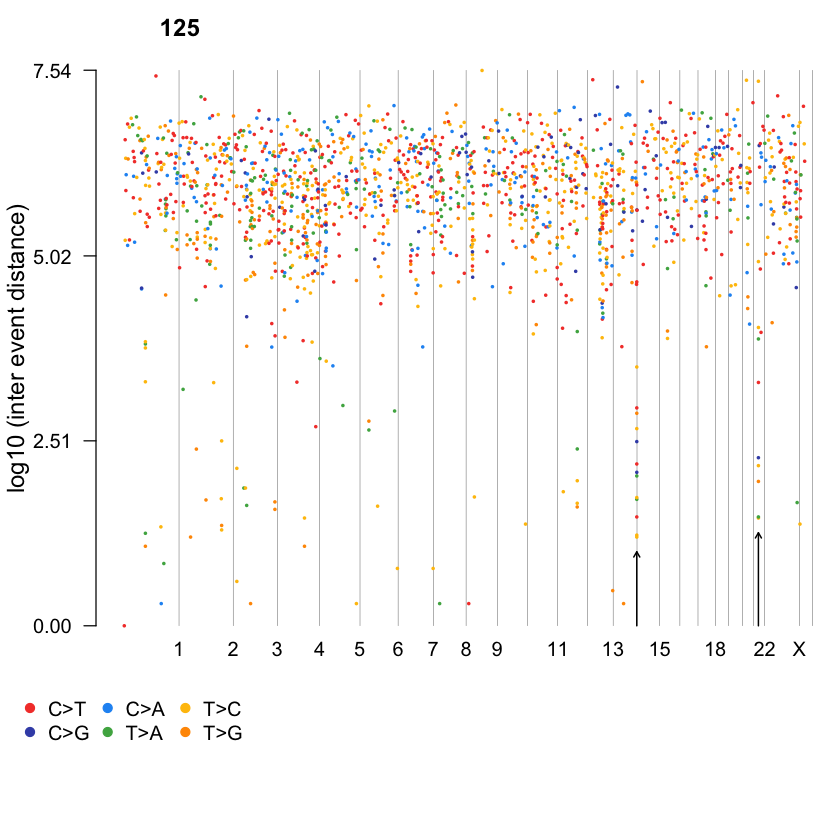

INFO [2023-06-07 15:56:13] Running kataegis
[1] 001-0002-03TD
Levels: 001-0002-03TD

No Kataegis called with parameters kmin=2, gamma=25, assembly=hg19, len=1000, nmut=6
[1] 003-0005-09TD
Levels: 003-0005-09TD

No Kataegis called with parameters kmin=2, gamma=25, assembly=hg19, len=1000, nmut=6
[1] 012-02-1TD
Levels: 012-02-1TD

No Kataegis called with parameters kmin=2, gamma=25, assembly=hg19, len=1000, nmut=6
[1] 125
Levels: 125

No Kataegis called with parameters kmin=2, gamma=25, assembly=hg19, len=1000, nmut=6
[1] 128
Levels: 128

No Kataegis called with parameters kmin=2, gamma=25, assembly=hg19, len=1000, nmut=6
INFO [2023-06-07 15:56:14] Running ClusteredMutations
[1] 1
[1] 001-0002-03TD
Levels: 001-0002-03TD
[1] 2
[1] 003-0005-09TD
Levels: 003-0005-09TD
[1] 3
[1] 012-02-1TD
Levels: 012-02-1TD
[1] 4
[1] 125
Levels: 125
[1] 5
[1] 128
Levels: 128
INFO [2023-06-07 15:56:14] Combining results and saving to data/resultsAlexandrovAllTools.RData
INFO [2023-06-07 15:56:14] Running all

Warning message in readChar(con, 5L, useBytes = TRUE):
"kann komprimierte Datei 'data/synthetic_data_processed.RData' nicht "offnen. Grund evtl. 'No such file or directory'"


ERROR: Error in readChar(con, 5L, useBytes = TRUE): kann Verbindung nicht "offnen


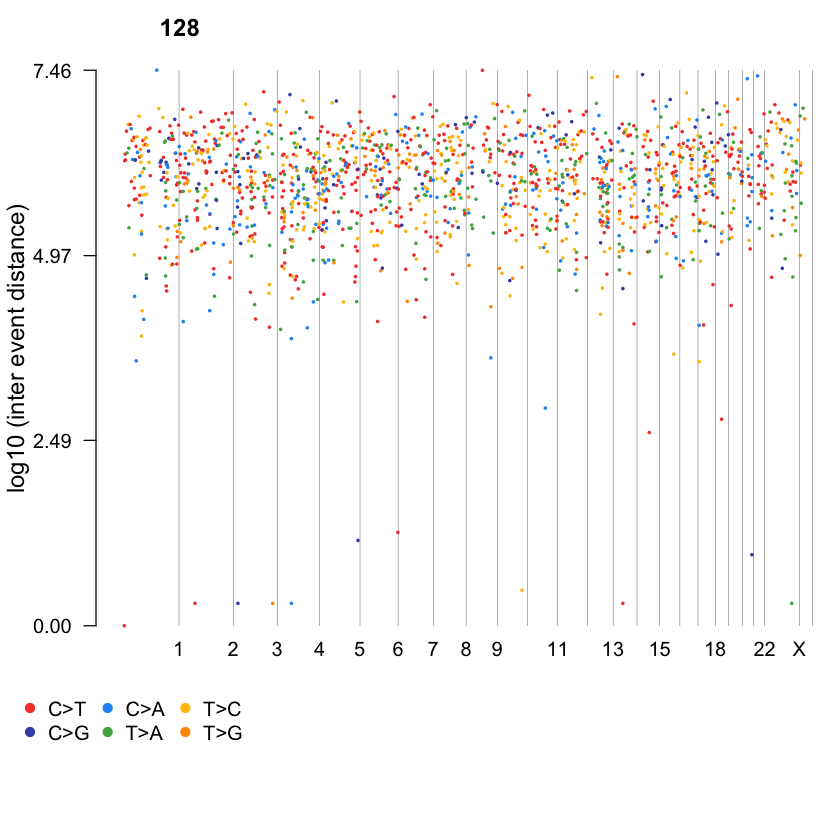

In [9]:
# Run the R-based tools on the Alexandrov et al. and synthetic datasets.
source("R/3.performRPackages.R")

# Remove the subset argument (or set to FALSE) to perform on all samples.
runTools_Alexandrov(data = "data/alexandrov_data_processed.RData", subset = TRUE)
runTools_Synthetic(data = "data/synthetic_data_processed.RData", subset = TRUE)


In [22]:
# Run the python-based SigProfiler on the Alexandrov et al. and synthetic datasets.
#source("R/4.performSigProfiler.R")
#runSigProfiler(dataAlexandrov = "data/alexandrov_data_processed.RData", dataSynthetic = "data/synthetic_data_processed.RData")


## Evaluate the results

Finally, we will evaluate the results of the various kataegis-detection packages. This will generate the figures and tables presented within our manuscript.
We begin by loading in all the results from the previous steps.

When the data is downloaded from Zenodo to reproduce the exact figures as presented within the manuscript, please change the `data/` path to the path where the RData objects were downloaded (`data/reproduction`).


In [10]:
# Load all required data and functions.
load(file = "data/resultsAlexandrovAllTools.RData")
load(file = "data/resultsAlexKatdetectr.RData")
load(file = "data/alexandrov_data_processed.RData")

source(file = "R/function_calculateMetrics.R")
source(file = "R/function_calculateConfusionVariants.R")
source(file = "R/ggplot_theme.R")

sampleOrigin <- read.csv("misc/sampleOrigin.txt", header = TRUE, sep = "\t")


### Descriptive overview of kataegis per TMB class (Alexandrov).


In [11]:
fociPerSample <- alexandrovData$reportedKataegis |>
    tibble::as_tibble() |>
    dplyr::group_by(.data$sampleNames) |>
    dplyr::summarise(
        nKataegisFoci = dplyr::n()
    )

alexandrovData$genomicVariants |>
    tibble::as_tibble() |>
    dplyr::group_by(.data$sampleNames) |>
    dplyr::summarise(
        .groups = "keep",
        totalVariants = dplyr::n(),
        kataegisVariants = sum(.data$kataegis),
        tissue = unique(.data$tissue)
    ) |>
    dplyr::mutate(
        TMB = base::round(.data$totalVariants / 3095, 3),
        TMBcat = dplyr::case_when(
            TMB < 1 ~ "low",
            TMB >= 1 & TMB < 10 ~ "mid",
            TMB >= 10 ~ "high"
        )
    ) |>
    dplyr::left_join(fociPerSample, by = "sampleNames") |>
    dplyr::mutate(nKataegisFoci = tidyr::replace_na(.data$nKataegisFoci, 0)) |>
    dplyr::group_by(TMBcat) |>
    dplyr::summarise(
        nSample = dplyr::n(),
        nKataegisSamples = base::sum(.data$nKataegisFoci != 0),
        totalVariants = base::sum(.data$totalVariants),
        kataegisVariants = base::sum(.data$kataegisVariants),
        nKataegisFoci = base::sum(.data$nKataegisFoci)
    )


TMBcat,nSample,nKataegisSamples,totalVariants,kataegisVariants,nKataegisFoci
<chr>,<int>,<int>,<int>,<int>,<int>
high,20,18,1433353,3107,336
low,301,45,299184,946,93
mid,186,89,1650214,5058,444


#### Combine results into a dataframe and add columns needed for further analysis.


In [12]:
kataegisSampleNames <- base::unique(alexandrovData$reportedKataegisFoci$sampleNames)
nVariantsInSample <- base::lapply(alexandrovData$genomicVariants, base::length)
nVariantsInSampleTib <- tibble::tibble(sampleNames = base::names(nVariantsInSample), totalVariantsInSample = base::unlist(nVariantsInSample))

# combine all results in a single tibble and add columns needed for subsequent analysis
resultsAlex <- dplyr::bind_rows(
    "MafTools" = resultsAlexandrovAllTools$maftools,
    "SeqKat" = resultsAlexandrovAllTools$seqkat,
    "ClusteredMutations" = resultsAlexandrovAllTools$clusteredMutations,
    "Katdetectr" = resultsAlexKatdetectr,
    "Kataegis" = resultsAlexandrovAllTools$kataegis,
    "SigProfilerClusters" = resultsAlexandrovAllTools$sigProfilerClusters,
    .id = "package"
) |>
    dplyr::distinct() |>
    dplyr::left_join(nVariantsInSampleTib, by = "sampleNames") |>
    dplyr::mutate(
        # calculate tumor mutational burden per sample by total number of variants / (length of the genome / 10^6) ~ 3095
        TMB = base::round(totalVariantsInSample / 3095, 3),
        TMBcat = dplyr::case_when(
            TMB < 1 ~ "low",
            TMB >= 1 & TMB < 10 ~ "mid",
            TMB >= 10 ~ "high"
        ),
        TMBcat = factor(TMBcat, levels = c("high", "mid", "low")),
        # specify if a kataegis foci was detected by the method
        detectedKataegisInSample = dplyr::if_else(is.na(.data$totalVariants), FALSE, TRUE),
        # specify if a sample contains a kataegis foci according to Alexandrov
        kataegisInSample = dplyr::if_else(sampleNames %in% kataegisSampleNames, TRUE, FALSE)
    ) |>
    dplyr::left_join(sampleOrigin, by = "sampleNames")

# Calculate the performance metrics for each method
resultsPerSampleAlex <- resultsAlex |>
    # summarise if a method detected kataegis in a sample
    dplyr::group_by(.data$package, .data$sampleNames, .data$TMB, .data$TMBcat, .data$runTime) |>
    dplyr::summarise(
        .groups = "keep",
        # is a kataegis foci detected by the method
        detectedKataegisInSample = any(detectedKataegisInSample),
        # is there actualy a kataegis foci in that sample
        kataegisInSample = any(kataegisInSample)
    ) |>
    dplyr::ungroup() |>
    dplyr::rowwise() |>
    # calculate confusion matrix
    dplyr::mutate(
        TP = .data$detectedKataegisInSample == TRUE & .data$kataegisInSample == TRUE,
        FP = .data$detectedKataegisInSample == TRUE & .data$kataegisInSample == FALSE,
        TN = .data$detectedKataegisInSample == FALSE & .data$kataegisInSample == FALSE,
        FN = .data$detectedKataegisInSample == FALSE & .data$kataegisInSample == TRUE
    ) |>
    dplyr::ungroup()

performancePerSampleAlex <- resultsPerSampleAlex |>
    dplyr::group_by(.data$package) |>
    dplyr::group_modify(~ calculateMetrics(.x), .keep = TRUE) |>
    dplyr::ungroup()

performancePerSampleTMB <- resultsPerSampleAlex |>
    dplyr::group_by(.data$package, .data$TMBcat) |>
    dplyr::group_modify(~ calculateMetrics(.x), .keep = TRUE) |>
    dplyr::ungroup()

# Calculate the performance of the kataegis detection tools regarding variant classification
resultsPerVariant <- resultsAlex |>
    dplyr::group_by(.data$package, .data$sampleNames) |>
    dplyr::group_modify(~ calculateConfusionVariants(.x, variantData = alexandrovData), .keep = TRUE) |>
    dplyr::ungroup()

performancePerVariantAlex <- resultsPerVariant |>
    dplyr::group_by(.data$package) |>
    dplyr::group_modify(~ calculateMetrics(.x), .keep = TRUE) |>
    dplyr::ungroup() |>
    arrange(desc(nMCC)) |>
    dplyr::select(package, accuracy, nMCC, F1, TPR, TNR)

performancePerVariantTMBAlex <- resultsPerVariant |>
    dplyr::group_by(.data$package, .data$TMBcat) |>
    dplyr::group_modify(~ calculateMetrics(.x), .keep = TRUE) |>
    dplyr::ungroup()


Warning message:
"Unknown or uninitialised column: `runTime`."
Warning message in mean.default(x$runTime, na.rm = TRUE):
"Argument ist weder numerisch noch boolesch: gebe NA zur"uck"
Warning message:
"Unknown or uninitialised column: `runTime`."
Warning message in mean.default(x$runTime, na.rm = TRUE):
"Argument ist weder numerisch noch boolesch: gebe NA zur"uck"
Warning message:
"Unknown or uninitialised column: `runTime`."
Warning message in mean.default(x$runTime, na.rm = TRUE):
"Argument ist weder numerisch noch boolesch: gebe NA zur"uck"
Warning message:
"Unknown or uninitialised column: `runTime`."
Warning message in mean.default(x$runTime, na.rm = TRUE):
"Argument ist weder numerisch noch boolesch: gebe NA zur"uck"
Warning message:
"Unknown or uninitialised column: `runTime`."
Warning message in mean.default(x$runTime, na.rm = TRUE):
"Argument ist weder numerisch noch boolesch: gebe NA zur"uck"
Warning message:
"Unknown or uninitialised column: `runTime`."
Warning message in mea

#### Visualize the MMC


`geom_line()`: Each group consists of only one observation.
i Do you need to adjust the group aesthetic?


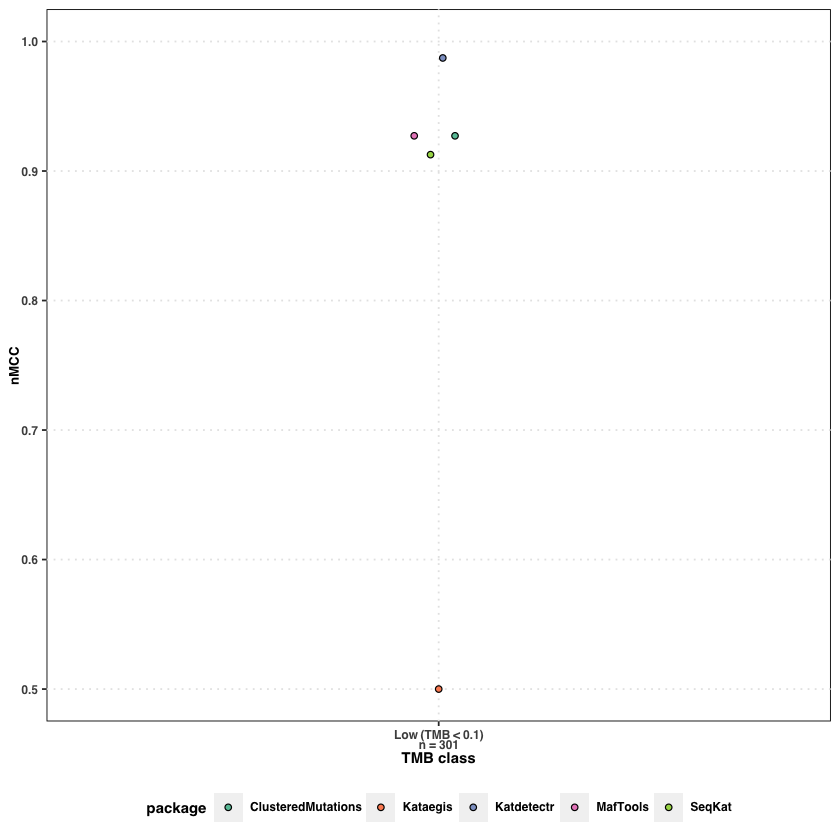

In [13]:
levelOrderTMB <- c("Low (TMB < 0.1)", "Mid (0.1 >= TMB < 10)", "High (TMB >= 10)")
levelOrderTMB <- c("low", "mid", "high")
levelOrderPackages <- factor(performancePerVariantAlex$package, levels = arrange(performancePerVariantAlex, nMCC)$package)

colors <- c("ClusteredMutations" = "#66C2A5", "Kataegis" = "#FC8D62", "Katdetectr" = "#8DA0CB", "MafTools" = "#E78AC3", "SeqKat" = "#A6D854", "SigProfilerClusters" = "#FFD92F")

plotnMMC.Alex <- performancePerVariantTMBAlex |>
    ggplot2::ggplot(ggplot2::aes(x = factor(TMBcat, levels = levelOrderTMB), y = nMCC, group = factor(package, levels = levelOrderPackages), colour = factor(package, levels = levelOrderPackages))) +
    ggplot2::geom_line(linewidth = 0.5, alpha = 0.4, lty = 11) +
    ggplot2::geom_point(ggplot2::aes(x = factor(TMBcat, levels = levelOrderTMB), y = nMCC, fill = package), col = "black", shape = 21, position = ggbeeswarm::position_quasirandom(width = .05)) +
    ggplot2::scale_fill_manual(values = colors) +
    ggplot2::scale_color_manual(values = colors, guide = "none") +
    ggplot2::scale_x_discrete(labels = c(
        "low" = "Low (TMB < 0.1)<br>n = 301",
        "mid" = "Mid (0.1 ≥ TMB < 10)<br>n = 186",
        "high" = "High (TMB ≥ 10)<br>n = 20"
    )) +
    ggplot2::ylim(0.5, 1) +
    ggplot2::labs(x = "TMB class", y = "nMCC") +
    theme_Job

plotnMMC.Alex


#### Visualize performance in variant classification split on TMB


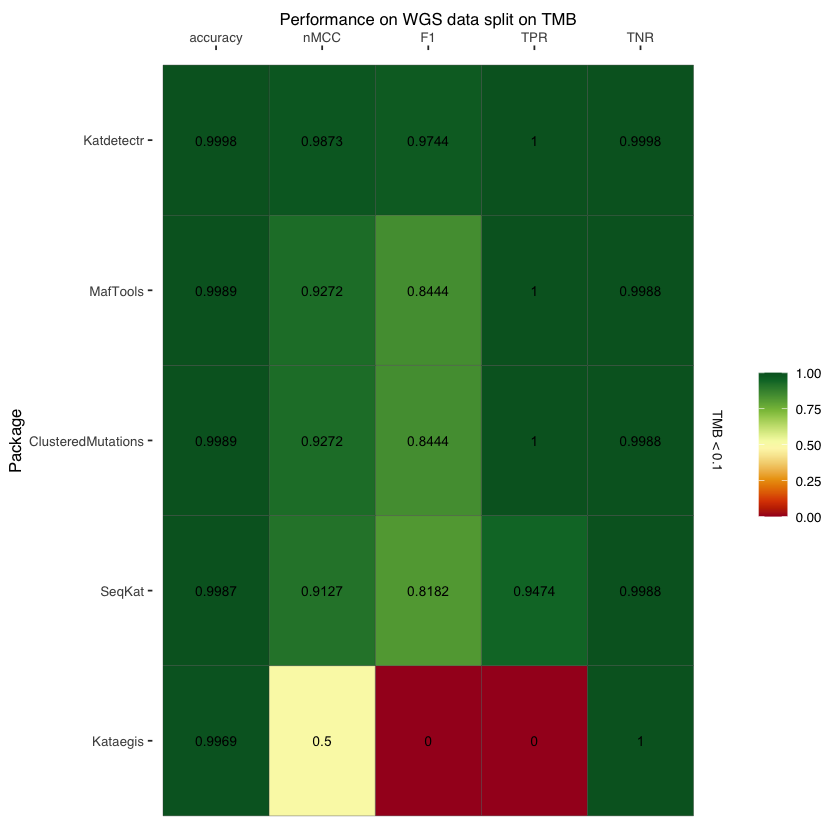

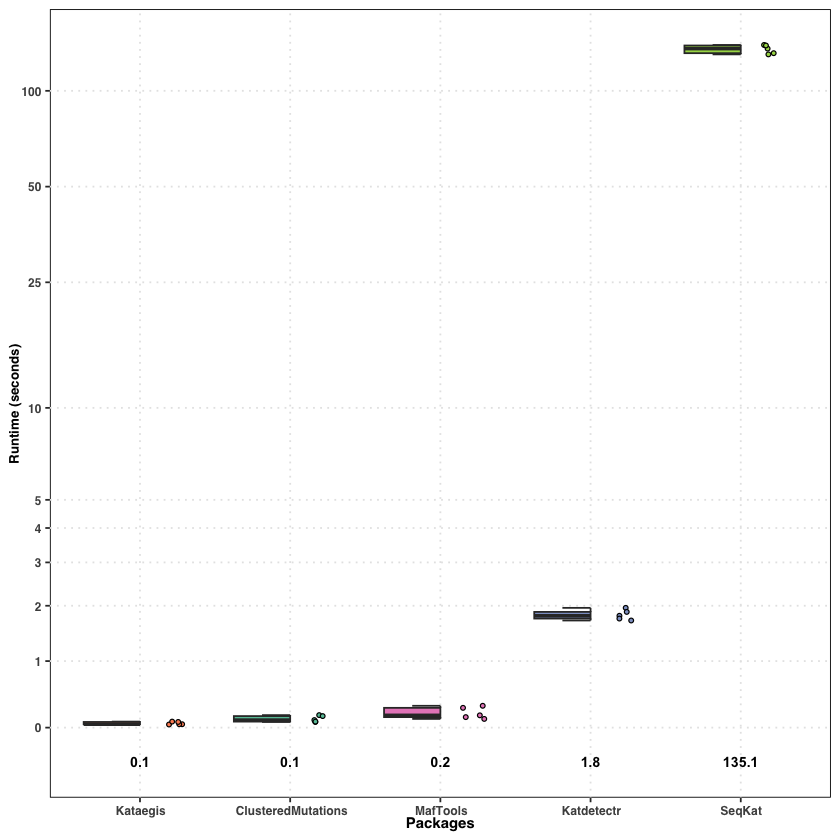

In [14]:
# facet labels
TMB.labs <- c("TMB >= 10", "0.1 >= TMB < 10", "TMB < 0.1")
names(TMB.labs) <- c("high", "mid", "low")

plotPerformancePerVariantTMB <- performancePerVariantTMBAlex |>
    tidyr::pivot_longer(
        cols = c(accuracy, TPR, TNR, F1, nMCC),
        names_to = "performanceMetric",
        values_to = "value"
    ) |>
    ggplot2::ggplot(ggplot2::aes(
        y = factor(package, levels = arrange(performancePerVariantAlex, nMCC)$package),
        x = factor(performanceMetric, levels = c("accuracy", "nMCC", "F1", "TPR", "TNR")),
        label = round(value, 4),
        fill = value
    )) +
    ggplot2::geom_tile(color = "grey25") +
    ggplot2::scale_fill_gradientn(colors = hcl.colors(20, "RdYlGn"), values = c(0, 0.5, 1), limits = c(0, 1), breaks = seq(0, 1, by = 0.25)) +
    ggplot2::ylab("Package") +
    ggplot2::xlab("Performance on WGS data split on TMB") +
    ggplot2::scale_x_discrete(position = "top") +
    ggplot2::theme(
        axis.text.x = ggplot2::element_text(angle = 0, ),
        text = ggplot2::element_text(size = 10, family = "Helvetica"),
        strip.background = ggplot2::element_blank(),
        panel.background = ggplot2::element_blank(),
        legend.title = ggplot2::element_blank()
    ) +
    ggplot2::geom_text(size = 2.9, angle = 0) +
    ggplot2::facet_grid(TMBcat ~ ., labeller = ggplot2::labeller(TMBcat = TMB.labs))

# Runtime.
colors = c('ClusteredMutations' = '#66C2A5', 'Kataegis' = '#FC8D62', 'Katdetectr' = '#8DA0CB', 'MafTools' = '#E78AC3', 'SeqKat' = '#A6D854', 'SigProfilerClusters' = '#FFD92F')
plotRunTimes.Alex <- resultsPerSampleAlex |> 
    ggplot2::ggplot(mapping = ggplot2::aes(x = factor(package, levels = arrange(performancePerSampleAlex, meanRuntime)$package), y = runTime, fill = package)) + 
    gghalves::geom_half_point_panel(size = 1, col = 'black', shape = 21) +
    gghalves::geom_half_boxplot(outlier.shape = NA) +
    ggplot2::scale_fill_manual(values = colors, guide = 'none') +
    ggplot2::scale_color_manual(values = colors, guide = 'none') +
    ggplot2::scale_y_continuous(trans = scales::pseudo_log_trans(), breaks = c(0:5, 10, 25, 50, seq(100, 500, by = 100), 1000)) +
    ggplot2::labs(y = "Runtime (seconds)", x = 'Packages') +
    ggplot2::geom_text(data = resultsPerSampleAlex %>% dplyr::group_by(package) %>% dplyr::summarise(mean = mean(runTime, na.rm = T)), ggplot2::aes(x = package, y = -.5, label = round(mean, 1)), size = 3, fontface='bold') +
    theme_Job


plotPerformancePerVariantTMB
plotRunTimes.Alex


#### Venn diagram that shows in which samples one or more kataegis foci is detected by the packages (WGS)


In [18]:
katDetectadd <- resultsPerSampleAlex |> 
    filter(package == "Katdetectr" & (TP | FP)) |> 
    pull(sampleNames)

clusteredMutationsadd <- resultsPerSampleAlex |> 
    filter(package == "ClusteredMutations" & (TP | FP)) |> 
    pull(sampleNames)

mafToolsadd <- resultsPerSampleAlex |> 
    filter(package == "MafTools" & (TP | FP)) |> 
    pull(sampleNames)

kataegisadd <- resultsPerSampleAlex |> 
    filter(package == "Kataegis" & (TP | FP)) |> 
    pull(sampleNames)

seqkatadd <- resultsPerSampleAlex |> 
    filter(package == "SeqKat" & (TP | FP)) |> 
    pull(sampleNames)

sigProfilerClustersadd <- resultsPerSampleAlex |> 
    filter(package == "SigProfilerClusters" & (TP | FP)) |> 
    pull(sampleNames)

alexandrovAdd <- resultsPerSampleAlex |> 
    filter(kataegisInSample) |> 
    pull(sampleNames)

VennDiagram::venn.diagram(
    x = list(katDetectadd, clusteredMutationsadd, mafToolsadd, sigProfilerClustersadd, alexandrovAdd),
    category.names = c("Katdetectr", "ClusteredMutations", "MafTools", "SigProfilerClusters", "Alexandrov et al., 2013"),
    filename = "venn_diagram_kataegis_samples.png",
    output=TRUE,
    imagetype="png",
    disable.logging = TRUE,
    cat.pos = c(0, 0, -120, 120, 0),
    cat.dist = c(0.18, 0.21, 0.21, 0.25, 0.21),
    fill = c("dodgerblue", "#66C2A5", "darkorange1", "#FFD92F", "orchid3"),
    alpha = 0.50,
    col = "black",
    rotation.degree	= -6
)


INFO [2023-06-07 16:21:38] $x
INFO [2023-06-07 16:21:38] list(katDetectadd, clusteredMutationsadd, mafToolsadd, sigProfilerClustersadd, 
INFO [2023-06-07 16:21:38]     alexandrovAdd)
INFO [2023-06-07 16:21:38] 
INFO [2023-06-07 16:21:38] $category.names
INFO [2023-06-07 16:21:38] c("Katdetectr", "ClusteredMutations", "MafTools", "SigProfilerClusters", 
INFO [2023-06-07 16:21:38]     "Alexandrov et al., 2013")
INFO [2023-06-07 16:21:38] 
INFO [2023-06-07 16:21:38] $filename
INFO [2023-06-07 16:21:38] [1] "venn_diagram_kataegis_samples.png"
INFO [2023-06-07 16:21:38] 
INFO [2023-06-07 16:21:38] $output
INFO [2023-06-07 16:21:38] [1] TRUE
INFO [2023-06-07 16:21:38] 
INFO [2023-06-07 16:21:38] $imagetype
INFO [2023-06-07 16:21:38] [1] "png"
INFO [2023-06-07 16:21:38] 
INFO [2023-06-07 16:21:38] $disable.logging
INFO [2023-06-07 16:21:38] [1] TRUE
INFO [2023-06-07 16:21:38] 
INFO [2023-06-07 16:21:38] $cat.pos
INFO [2023-06-07 16:21:38] c(0, 0, -120, 120, 0)
INFO [2023-06-07 16:21:38] 
INFO

[1] 1

![Concordance in kataegis detection in WGS dataset per sample](venn_diagram_kataegis_samples.png)

#### Generate Venn-diagram of of kataegis foci detected by the packages.

In [17]:
findOverlappingFoci <- function(x){
    
    allFociInSample <- x
    
    Focireduced <- allFociInSample %>% 
        GenomicRanges::makeGRangesFromDataFrame(keep.extra.columns = TRUE) %>% 
        GenomicRanges::reduce(min.gapwidth = 0, ignore.strand = TRUE, with.revmap = TRUE)
    
    names(Focireduced$revmap) <- paste0(unique(allFociInSample$sampleNames), "_foci_", seq(length(Focireduced$revmap)))
    
    fociList <- lapply(Focireduced$revmap, function(i){
        allFociInSample$package[i]
    })
    
    focidf <- lapply(seq_len(length(fociList)), function(i){
        tibble(package = fociList[[i]], foci = names(fociList)[i])
    }) |> bind_rows()
    
    return(focidf)
}

alexKataegis <- alexandrovData$reportedKataegisFoci |> 
    as_tibble() |> 
    mutate(package = "Alexandrov")

resultsAlexPerFoci <- resultsAlex |> 
    filter(detectedKataegisInSample) |>  
    bind_rows(alexKataegis) |> 
    group_by(sampleNames) |> 
    group_modify(~ findOverlappingFoci(.x), keep = TRUE) |> 
    ungroup()

katdetectrFoci <- resultsAlexPerFoci |> 
    filter(package == "Katdetectr") |> 
    pull(foci)

clusteredMutationsFoci <- resultsAlexPerFoci |> 
    filter(package == "ClusteredMutations") |> 
    pull(foci)

maftoolsFoci <- resultsAlexPerFoci |> 
    filter(package == "MafTools") |> 
    pull(foci)

kataegisPFoci <- resultsAlexPerFoci |> 
    filter(package == "Kataegis") |> 
    pull(foci)

seqKatFoci <- resultsAlexPerFoci |> 
    filter(package == "SeqKat") |> 
    pull(foci)

sigProfilerClustersFoci <- resultsAlexPerFoci |> 
    filter(package == "SigProfilerClusters") |> 
    pull(foci)

alexandrovFoci <- resultsAlexPerFoci |> 
    filter(package == "Alexandrov") |> 
    pull(foci)


VennDiagram::venn.diagram(
    x = list(katdetectrFoci, clusteredMutationsFoci, maftoolsFoci, sigProfilerClustersFoci, alexandrovFoci),
    category.names = c("Katdetectr", "ClusteredMutations", "MafTools", "SigProfilerClusters", "Alexandrov et al., 2013"),
    filename = "venn_diagram_kataegis_foci.png",
    output=T,
    imagetype="png",
    disable.logging = TRUE,
    
    cat.pos = c(0, 0, -120, 120, 0),
    cat.dist = c(0.18, 0.21, 0.21, 0.25, 0.21),
    fill = c("dodgerblue", "#66C2A5", "darkorange1", "#FFD92F", "orchid3"),
    alpha = 0.50,
    col = "black",
    rotation.degree	= -6
)

Warning message:
"The `keep` argument of `group_modify()` is deprecated as of dplyr 1.0.0.
i Please use the `.keep` argument instead."
Warning message in .normarg_strand(strand, seqnames):
"missing values in 'strand' converted to "*""
Warning message in .normarg_strand(strand, seqnames):
"missing values in 'strand' converted to "*""


INFO [2023-06-07 16:20:11] $x
INFO [2023-06-07 16:20:11] list(katdetectrFoci, clusteredMutationsFoci, maftoolsFoci, sigProfilerClustersFoci, 
INFO [2023-06-07 16:20:11]     alexandrovFoci)
INFO [2023-06-07 16:20:11] 
INFO [2023-06-07 16:20:11] $category.names
INFO [2023-06-07 16:20:11] c("Katdetectr", "ClusteredMutations", "MafTools", "SigProfilerClusters", 
INFO [2023-06-07 16:20:11]     "Alexandrov et al., 2013")
INFO [2023-06-07 16:20:11] 
INFO [2023-06-07 16:20:11] $filename
INFO [2023-06-07 16:20:11] [1] "venn_diagram_kataegis_foci.png"
INFO [2023-06-07 16:20:11] 
INFO [2023-06-07 16:20:11] $output
INFO [2023-06-07 16:20:11] T
INFO [2023-06-07 16:20:11] 
INFO [2023-06-07 16:20:11] $imagetype
INFO [2023-06-07 16:20:11] [1] "png"
INFO [2023-06-07 16:20:11] 
INFO [2023-06-07 16:20:11] $disable.logging
INFO [2023-06-07 16:20:11] [1] TRUE
INFO [2023-06-07 16:20:11] 
INFO [2023-06-07 16:20:11] $cat.pos
INFO [2023-06-07 16:20:11] c(0, 0, -120, 120, 0)
INFO [2023-06-07 16:20:11] 
INFO [20

[1] 1

![Concordance in kataegis detection in WGS dataset per kataegis focus](venn_diagram_kataegis_foci.png)

#### Examples of kataegis foci.

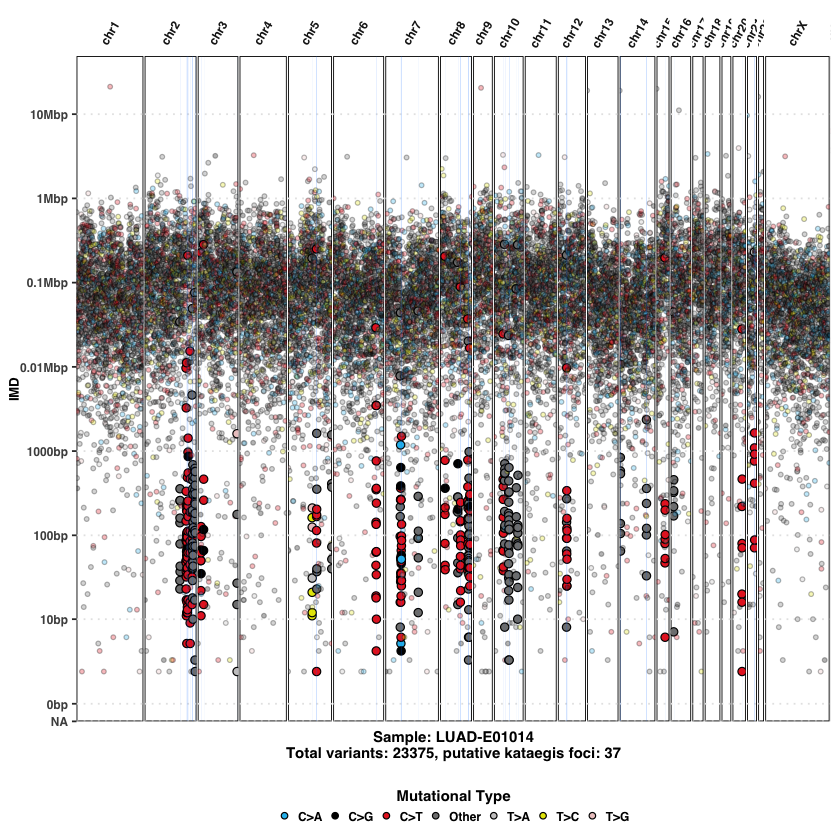

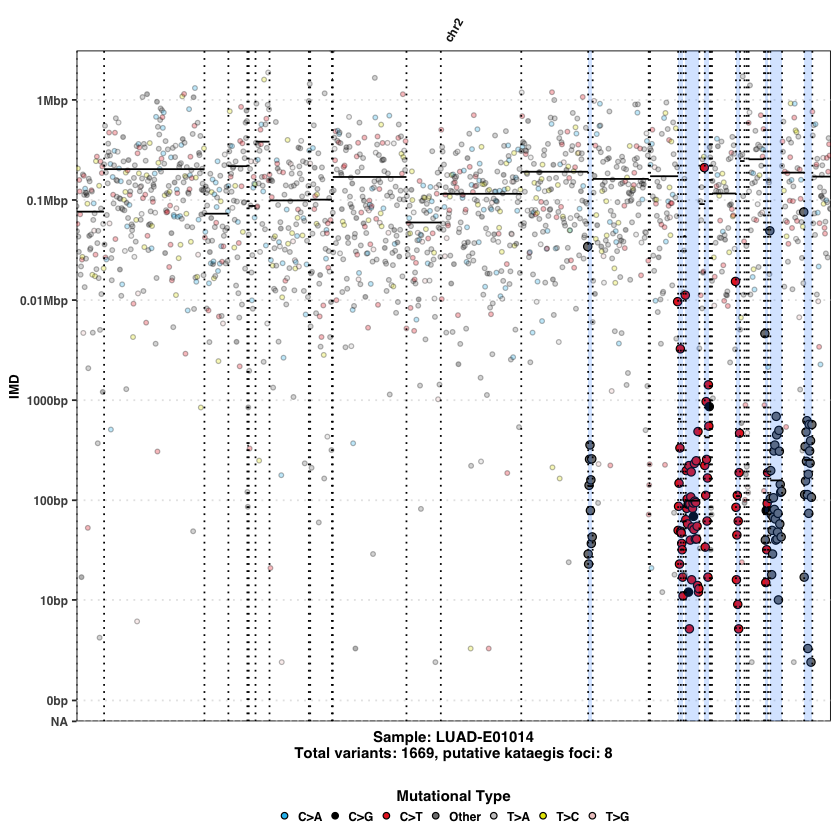

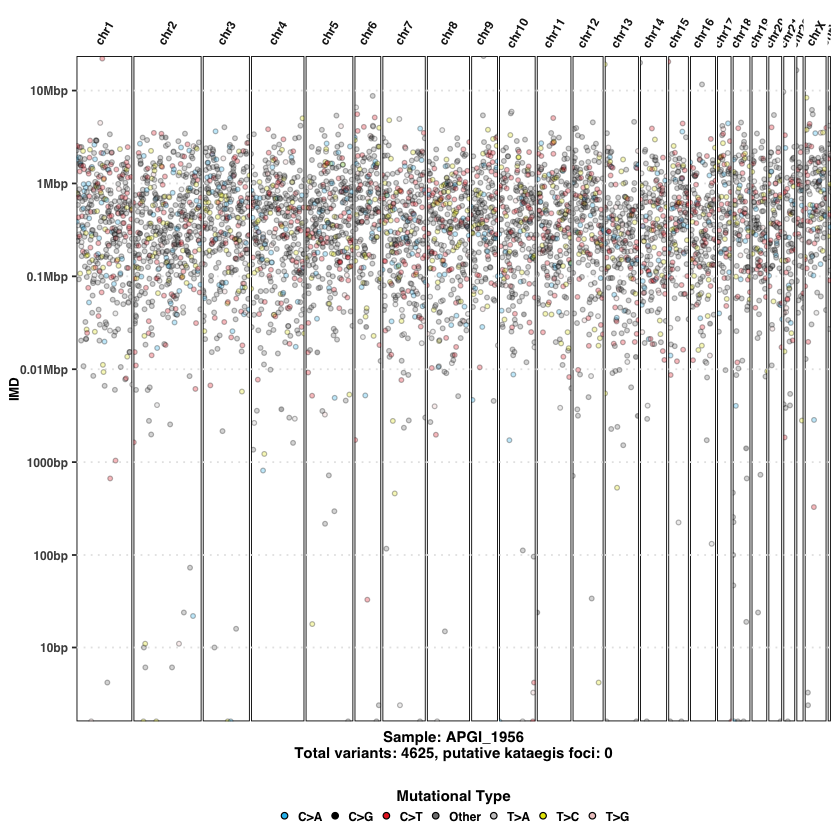

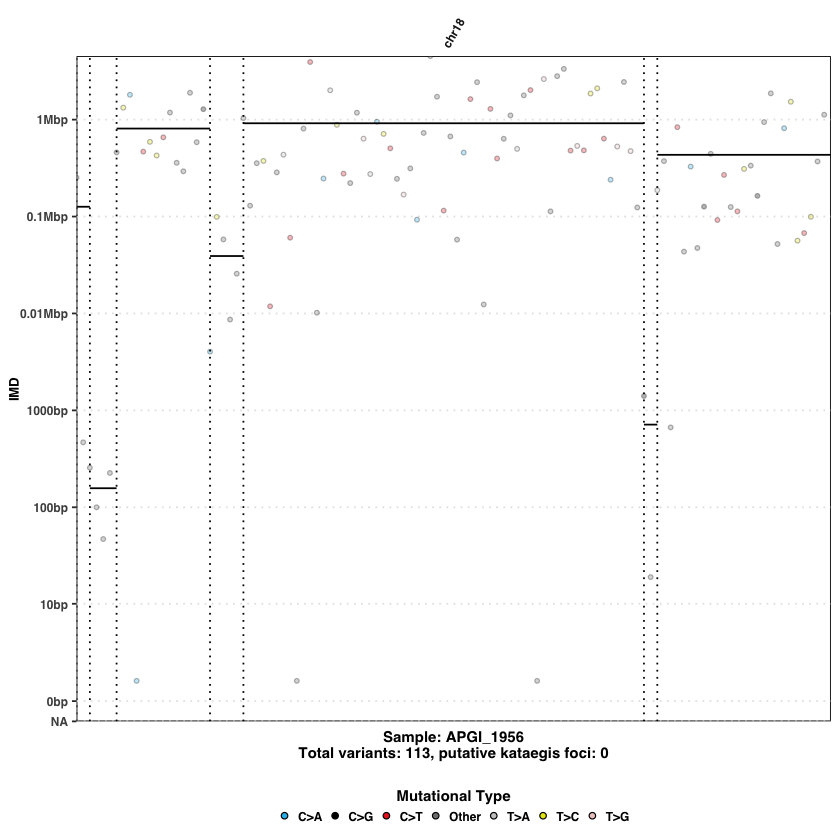

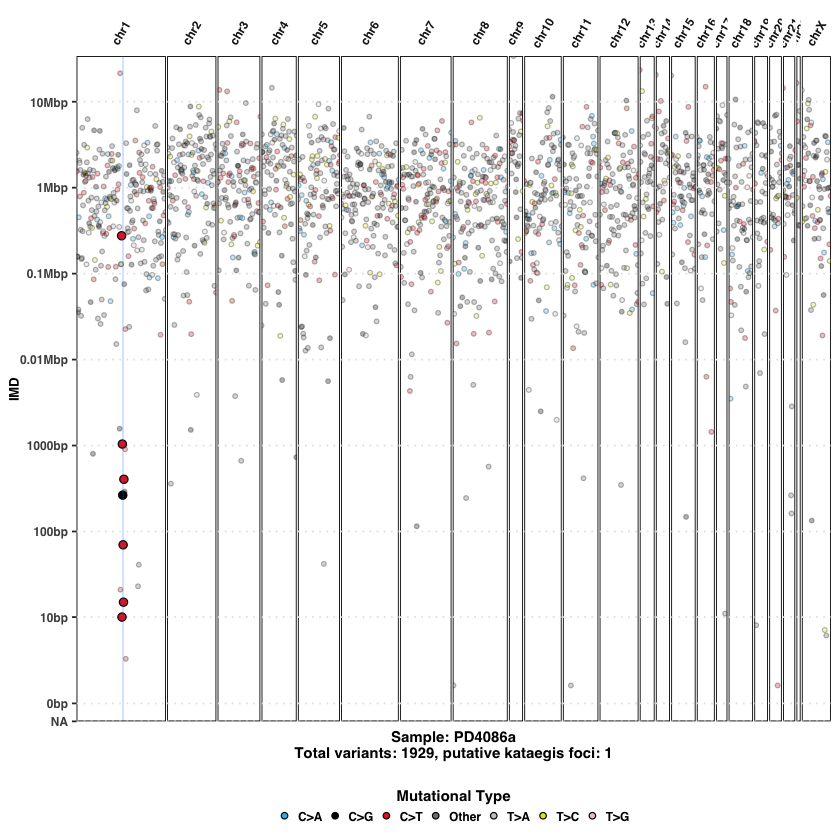

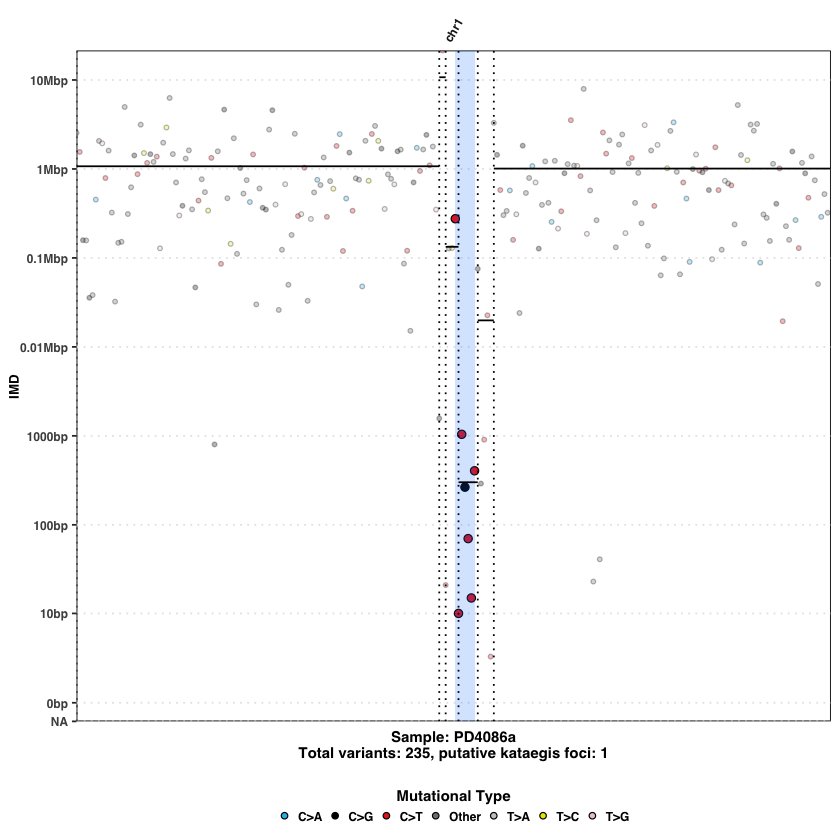

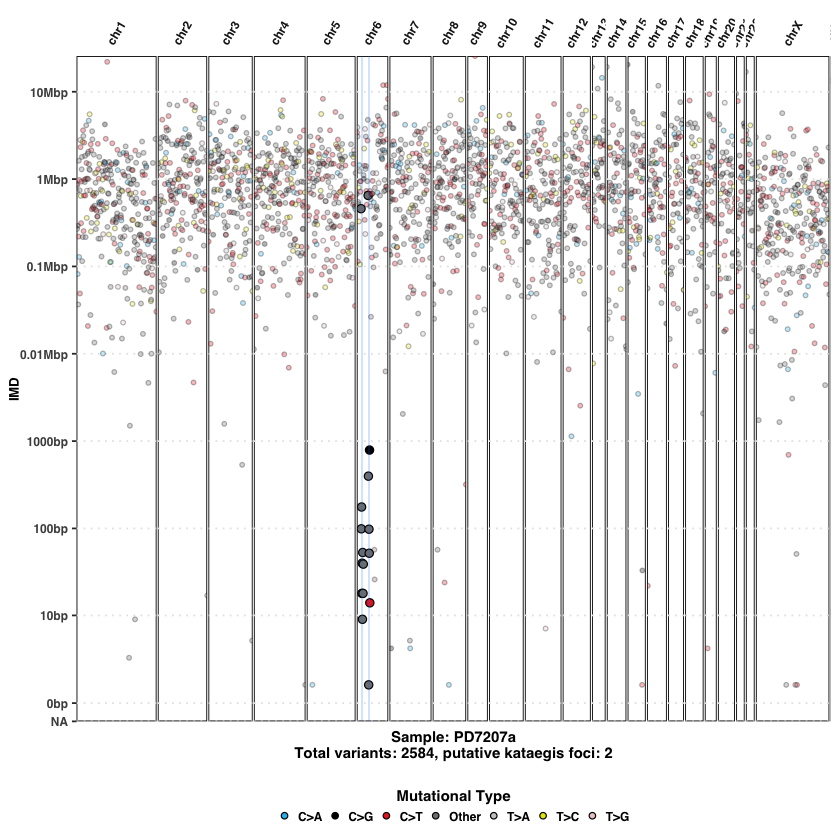

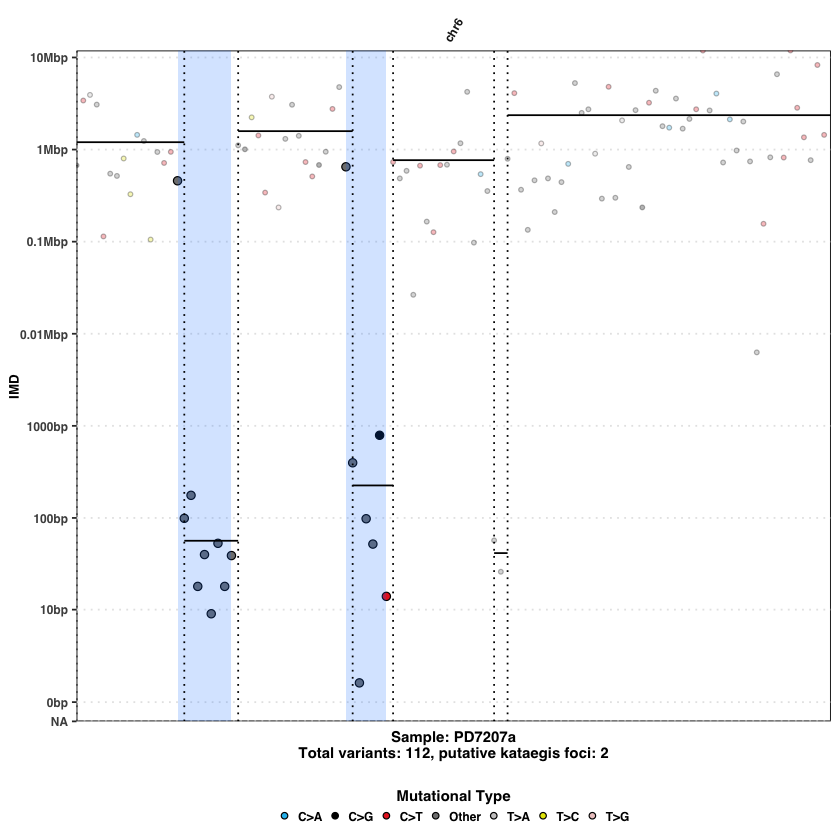

In [20]:
kdLUADE01014 <- katdetectr::detectKataegis(alexandrovData$genomicVariants$"LUAD-E01014")
rfpkdLUADE01014 <- katdetectr::rainfallPlot(kdLUADE01014)
rfpkdLUADE01014chr2 <- katdetectr::rainfallPlot(kdLUADE01014, showSequence = "chr2", showSegmentation = TRUE)

rfpkdLUADE01014
rfpkdLUADE01014chr2


kdAPGI_1956 <- katdetectr::detectKataegis(alexandrovData$genomicVariants$"APGI_1956")
rfpAPGI_1956 <- katdetectr::rainfallPlot(kdAPGI_1956)
APGI_1956chr18 <- katdetectr::rainfallPlot(kdAPGI_1956, showSequence = "chr18", showSegmentation = TRUE)

rfpAPGI_1956
APGI_1956chr18

kdPD4086a <- katdetectr::detectKataegis(alexandrovData$genomicVariants$"PD4086a")
rfpPD4086a <- katdetectr::rainfallPlot(kdPD4086a)
PD4086achr1 <- katdetectr::rainfallPlot(kdPD4086a, showSequence = "chr1", showSegmentation = TRUE)

rfpPD4086a
PD4086achr1

kdPD7207a <- katdetectr::detectKataegis(alexandrovData$genomicVariants$"PD7207a")
rfpPD7207a <- katdetectr::rainfallPlot(kdPD7207a)
rfpPD7207achr6 <- katdetectr::rainfallPlot(kdPD7207a, showSequence = "chr6", showSegmentation = TRUE)

rfpPD7207a
rfpPD7207achr6

## Session information


In [21]:
sessionInfo()


R version 4.2.3 (2023-03-15)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Ventura 13.4

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRlapack.dylib

locale:
[1] C

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] BiocManager_1.30.20         maftools_2.14.0            
 [3] kataegis_0.99.2             ClusteredMutations_1.0.1   
 [5] seriation_1.4.2             doMC_1.3.8                 
 [7] SeqKat_0.0.8                doParallel_1.0.17          
 [9] iterators_1.0.14            foreach_1.5.2              
[11] pbapply_1.7-0               VariantAnnotation_1.44.1   
[13] Rsamtools_2.14.0            Biostrings_2.66.0          
[15] XVector_0.38.0              SummarizedExperiment_1.28.0
[17] Biobase_2.58.0      